##Librerias

In [1]:
!pip install tensorflow
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
# tf.python.control_flow_ops = tf #esta línea evita un conflicto entre Keras y Tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from scikeras.wrappers import KerasClassifier


import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import   OneHotEncoder, StandardScaler



In [4]:
from tensorflow.python.client import device_lib

def gpuon():
    local_device_protos = device_lib.list_local_devices()
    print([x.name for x in local_device_protos if x.device_type == 'GPU'])

gpuon()

['/device:GPU:0']


In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan  9 09:05:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |    312MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Carga de datos

In [6]:
df_all_20_21 = pd.read_csv("/content/drive/MyDrive/TFM/datos/df_all_20_21.csv", sep = ";")

In [7]:
df_all_20_21.index = df_all_20_21.fecha  ##Set_index('fecha')
df_all_20_21 = df_all_20_21.drop('fecha', axis=1)
df_all_20_21

,indicativo,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,...,vulner,ocurrencia,municipio,cod_municipio,total_viajes_estacion,total_viajes_km_estacion,laborable,dayofyear,weekend,mes
fecha,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0002I,0.0,12.4,12.1,11.9,0.3,8.3,457.0,1020.7,1020.1,...,Molt Alta,0,Vandellos l’Hospitalet de l’Infant,43162,0.0,0.0,3,1,0,1
2015-01-01,WE,0.0,11.3,11.1,10.7,5.3,7.8,449.0,1027.2,1021.7,...,Molt Alta,0,Vilanova del Vallès,8946,0.0,0.0,3,1,0,1
2015-01-01,WG,0.0,8.5,8.1,7.6,0.8,2.3,428.0,1020.0,1019.6,...,Moderada,0,Algerri,25528,0.0,0.0,3,1,0,1
2015-01-01,WI,0.0,7.8,7.6,7.4,2.1,4.1,468.0,1031.5,1031.3,...,Baixa,0,Maials,25761,0.0,0.0,3,1,0,1
2015-01-01,WJ,0.0,12.3,11.7,11.3,1.0,2.4,449.0,1000.2,999.7,...,Moderada,0,El Masroig,43675,0.0,0.0,3,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,UN,0.0,14.8,14.3,14.0,1.4,3.5,526.0,954.0,953.8,...,Alta,0,Cassà de la Selva,17462,0.0,0.0,1,32,0,2
2022-02-01,UO,0.0,14.0,13.7,13.3,5.5,10.2,574.0,1023.8,1023.4,...,Moderada,0,Fornells de la Selva,17466,0.0,0.0,1,32,0,2
2022-02-01,UP,0.0,13.6,13.3,13.1,2.2,4.3,544.0,1013.9,1013.6,...,Molt Alta,0,Cabrils,8489,0.0,0.0,1,32,0,2


In [8]:
df_all_20_21 = df_all_20_21.loc['2020-02-21':'2021-05-09'] 
df_all_20_21.shape

(84515, 25)

##1. Division de datos (UnderSampling Manual)
---



In [ ]:
df_all_20_21.groupby("ocurrencia").count()

,indicativo,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,...,peligro,vulner,municipio,cod_municipio,total_viajes_estacion,total_viajes_km_estacion,laborable,dayofyear,weekend,mes
ocurrencia,,,,,,,,,,,,,,,,,,,,,
0,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,...,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133
1,382,382,382,382,382,382,382,382,382,382,...,382,382,382,382,382,382,382,382,382,382


In [ ]:
df_all_20_21.groupby("ocurrencia").count().columns

Index(['indicativo', 'prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha',
       'sol', 'presMax', 'presMin', 'rhum', 'altitud',
       'porcentaje_pendiente_total', 'alto_riesgo', 'peligro', 'vulner',
       'municipio', 'cod_municipio', 'total_viajes_estacion',
       'total_viajes_km_estacion', 'laborable', 'dayofyear', 'weekend', 'mes'],
      dtype='object')

In [ ]:
df_ocurrencia_0 = df_all_20_21[df_all_20_21["ocurrencia"]==0].sample(382)

In [ ]:
df_ocurrencia_1 = df_all_20_21[df_all_20_21["ocurrencia"]==1]

In [ ]:
df_all_20_21 =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_all_20_21.shape

(764, 25)

In [ ]:
x = df_all_20_21['indicativo'].unique()
len(x)

185

In [ ]:
X = df_all_20_21.drop( ['ocurrencia', 'municipio', 'cod_municipio', 'indicativo', 'total_viajes_km_estacion'], axis=1)
y = df_all_20_21['ocurrencia']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train

,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,rhum,altitud,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,total_viajes_estacion,laborable,dayofyear,weekend,mes
fecha,,,,,,,,,,,,,,,,,,,,
2021-03-11,0.0,20.5,20.0,19.7,2.3,5.4,620.0,1022.1,1021.6,37.0,450.0,5.2,Sí,Molt Alt,Moderada,6.301526e+04,3,70,0,3
2021-02-01,0.0,11.7,11.4,11.1,7.0,13.7,582.0,917.5,917.1,60.0,791.0,4.1,Sí,Molt Alt,Moderada,0.000000e+00,0,32,0,2
2020-12-09,0.0,13.1,12.5,11.9,10.3,21.1,492.0,1003.7,999.6,81.0,869.0,3.5,Sí,Moderat,Moderada,0.000000e+00,2,344,0,12
2020-08-23,0.0,30.8,29.7,28.9,2.8,6.1,472.0,1002.4,1002.1,47.0,178.0,2.5,Sí,Molt Alt,Molt Alta,2.271874e+05,6,236,1,8
2020-09-17,0.0,30.6,24.4,18.1,1.9,6.1,3.1,994.5,991.1,50.0,264.0,9.0,Sí,Exclos,Moderada,1.295486e+04,3,261,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-29,0.0,27.3,27.0,26.8,1.6,4.4,980.0,1015.8,1015.4,37.0,567.0,6.8,Sí,Alt,Mitja,0.000000e+00,4,150,0,5
2020-10-28,0.0,20.8,20.4,20.1,3.5,6.5,445.0,989.0,988.8,39.0,423.0,2.5,Sí,Alt,Molt Alta,1.305669e+05,2,302,0,10
2020-08-12,0.0,33.2,32.8,32.3,6.2,7.8,911.0,999.4,995.5,56.0,142.0,5.2,Sí,Molt Alt,Mitja,1.140940e+05,2,225,0,8


## 1.2. Normalizacion datos



In [ ]:
# normalizacion de los datos numericos
numericalCols_train = X_train[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total", "total_viajes_estacion" ]]  
numericalCols_test = X_test[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total", "total_viajes_estacion" ]]  

scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((611, 13), (153, 13))

In [ ]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train = X_train[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	vulner
categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()

# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test = X_test[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	 y vulner
categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

categoricalCols_train.shape, categoricalCols_test.shape

((611, 12), (153, 12))

In [ ]:
Other_var_train = X_train[['laborable', 	'dayofyear', 	'weekend', 	'mes']]
Other_var_test = X_test[['laborable', 	'dayofyear', 	'weekend', 	'mes']]  #alto_riesgo	peligro	 y vulner

In [ ]:
df_train_scaled = np.concatenate((numericalCols_train_scaled , categoricalCols_train, Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled , categoricalCols_test, Other_var_test), axis=1)

In [ ]:
df_train_scaled.shape, y_train.shape, df_test_scaled.shape, y_test.shape

((611, 29), (611,), (153, 29), (153,))

In [ ]:
X_train = df_train_scaled.reshape(df_train_scaled.shape[0],df_train_scaled.shape[1],1)
X_train.shape, y_train.shape

((611, 29, 1), (611,))

In [ ]:
X_test = df_test_scaled.reshape(df_test_scaled.shape[0],df_test_scaled.shape[1],1)
X_test.shape, y_test.shape

((153, 29, 1), (153,))

#Division de datos (UnderSampling Manual)

---



# 1.3. Model LSTM (df_all_20_21)


Vamos a generar una LSTM con dos capas

1. LSTM - Es la capa que trabaja en la clasificación. Donde se indica el numero de neuronas
2. Capa de dropout (Apagado de neuronas)
3. Capa de activacion sigmoide ya que estamos ante una clasificación biaria (0-1)
4. Una única neurona de salida con un sigmoide

In [ ]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer


def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 32):
    model=Sequential()
    model.add(InputLayer((29,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(29, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
model = modelLSTM()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 29)                5829      
                                                                 
 dropout_1 (Dropout)         (None, 29)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 30        
                                                                 
Total params: 167,459
Trainable params: 167,459
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Entrenamos el modelo
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.7124 - accuracy: 0.4877

20/20 [==============================] - 11s 255ms/step - loss: 0.7124 - accuracy: 0.4877 - val_loss: 0.6964 - val_accuracy: 0.4575
Epoch 2/20
11/20 [===============>..............] - ETA: 0s - loss: 0.7195 - accuracy: 0.4659

20/20 [==============================] - 4s 230ms/step - loss: 0.7178 - accuracy: 0.4730 - val_loss: 0.6959 - val_accuracy: 0.5163
Epoch 3/20
20/20 [==============================] - 0s 7ms/step - loss: 0.7041 - accuracy: 0.5188 - val_loss: 0.6960 - val_accuracy: 0.4902
Epoch 4/20
11/20 [===============>..............] - ETA: 0s - loss: 0.6977 - accuracy: 0.5398

20/20 [==============================] - 4s 231ms/step - loss: 0.7048 - accuracy: 0.5041 - val_loss: 0.6840 - val_accuracy: 0.5752
Epoch 5/20
20/20 [==============================] - 0s 10ms/step - loss: 0.6761 - accuracy: 0.5810 - val_loss: 0.6900 - val_accuracy: 0.5621
Epoch 6/20
20/20 [==============================] - 0s 9ms/step - loss: 0.6897 - accuracy: 0.5401 - val_loss: 0.6940 - val_accuracy: 0.5817
Epoch 7/20
20/20 [==============================] - 0s 10ms/step - loss: 0.6902 - accuracy: 0.4926 - val_loss: 0.6841 - val_accuracy: 0.5752
Epoch 8/20
15/20 [=====================>........] - ETA: 0s - loss: 0.7057 - accuracy: 0.5229

20/20 [==============================] - 6s 297ms/step - loss: 0.7013 - accuracy: 0.5303 - val_loss: 0.6712 - val_accuracy: 0.6144
Epoch 9/20
18/20 [==========================>...] - ETA: 0s - loss: 0.6921 - accuracy: 0.5573

20/20 [==============================] - 4s 210ms/step - loss: 0.6913 - accuracy: 0.5581 - val_loss: 0.6677 - val_accuracy: 0.6144
Epoch 10/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6879 - accuracy: 0.5679 - val_loss: 0.6682 - val_accuracy: 0.6144
Epoch 11/20
11/20 [===============>..............] - ETA: 0s - loss: 0.6887 - accuracy: 0.5426

20/20 [==============================] - 4s 235ms/step - loss: 0.6844 - accuracy: 0.5516 - val_loss: 0.6670 - val_accuracy: 0.6144
Epoch 12/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6956 - accuracy: 0.5548 - val_loss: 0.6696 - val_accuracy: 0.6144
Epoch 13/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6837 - accuracy: 0.5745 - val_loss: 0.6696 - val_accuracy: 0.6209
Epoch 14/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6817 - accuracy: 0.5646 - val_loss: 0.6744 - val_accuracy: 0.6078
Epoch 15/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.5516 - val_loss: 0.6729 - val_accuracy: 0.6013
Epoch 16/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6849 - accuracy: 0.5516 - val_loss: 0.6771 - val_accuracy: 0.6013
Epoch 17/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6833 - accuracy: 0.5679 - val_loss: 0.6747 - val_accuracy: 0.6013
Epoch 18/20
20/20 [====

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

5/5 - 0s - loss: 0.6688 - accuracy: 0.6209 - 31ms/epoch - 6ms/step
accuracy: 62.09%


In [ ]:
y_pred_model_1 = model.predict(X_test)

5/5 [==============================] - 0s 3ms/step


In [ ]:
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test, y_pred_model1))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65        74
           1       0.00      0.00      0.00        79

    accuracy                           0.48       153
   macro avg       0.24      0.50      0.33       153
weighted avg       0.23      0.48      0.32       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[74  0]
 [79  0]]


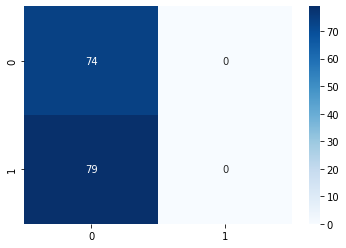

In [ ]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

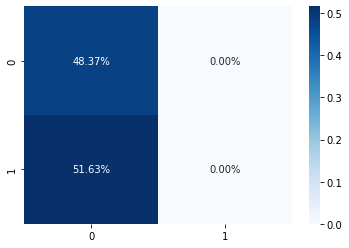

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred_model1) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred_model1, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred_model1, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred_model1))

Conjunto de datos de validación
  Exactitud:     0.48366
  Precisión:     0.24183
  Exhaustividad: 0.50000
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        74
           1       0.00      0.00      0.00        79

    accuracy                           0.48       153
   macro avg       0.24      0.50      0.33       153
weighted avg       0.23      0.48      0.32       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: 

# 1.3.1 GridSearch -  Modelo LSTM (df_all_20_21) Division manual con undersampler

In [ ]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.590870 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.531961 (0.039006) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.495908 (0.003666) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.495908 (0.003666) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.551633 (0.047349) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.507384 (0.021118) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.495908 (0.003666) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [ ]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f97c13e8700>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

In [ ]:
# print classification report
y_pred = final_model.predict(X_test.astype(np.float32))

In [ ]:
print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

Conjunto de datos de validación
  Exactitud:     0.56209
  Precisión:     0.56195
  Exhaustividad: 0.55799
              precision    recall  f1-score   support

           0       0.56      0.43      0.49        74
           1       0.56      0.68      0.62        79

    accuracy                           0.56       153
   macro avg       0.56      0.56      0.55       153
weighted avg       0.56      0.56      0.55       153



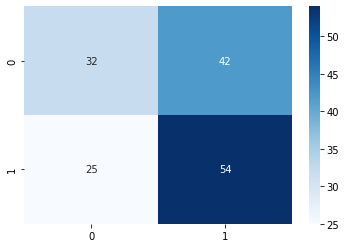

In [ ]:
y_pred = final_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test_1, y_pred))

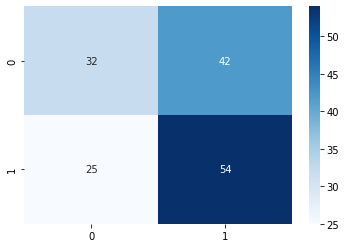

In [ ]:
y_pred = (final_model.predict_proba(X_test)[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test_1, y_pred))

# 1.4. Model LSTM clases balanceadas con SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE 
X_smote , y_smote = SMOTE().fit_resample( df_train_scaled, y_train)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_smote.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote == 0)))

Before OverSampling, counts of label '1': 303
Before OverSampling, counts of label '0': 308 

After OverSampling, the shape of train_X: (616, 29)
After OverSampling, the shape of train_y: (616,) 

After OverSampling, counts of label '1': 308
After OverSampling, counts of label '0': 308


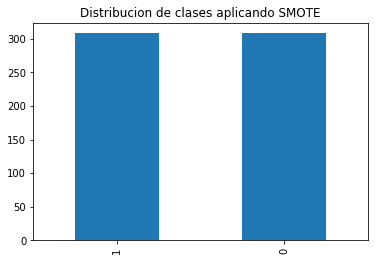

In [ ]:
pd.Series(y_smote).value_counts().plot(kind='bar', title='Distribucion de clases aplicando SMOTE')

Este gráfico muestra claramente que ahora tenemos una gran cantidad de incendios que antes no teníamos. Esos son todos los puntos de datos sintéticos que se ha creado con SMOTE.



In [ ]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_smote = X_smote.reshape(X_smote.shape[0],X_smote.shape[1],1)
X_smote.shape, y_smote.shape

((616, 29, 1), (616,))

In [ ]:
X_smote_float=X_smote.astype(np.float32)

In [ ]:
y_smote_int = y_smote.astype(np.int32)

In [ ]:
#Entrenamos el modelo
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=10)

model_2 = modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 32)

model_2.fit(X_smote_float, y_smote_int,validation_data=(X_test, y_test),epochs=20,callbacks=[cp, earlyStop])

Epoch 1/20
17/20 [========================>.....] - ETA: 0s - loss: 0.7145 - accuracy: 0.5018

20/20 [==============================] - 8s 286ms/step - loss: 0.7143 - accuracy: 0.5065 - val_loss: 0.6942 - val_accuracy: 0.4837
Epoch 2/20
20/20 [==============================] - 0s 7ms/step - loss: 0.7005 - accuracy: 0.5162 - val_loss: 0.7027 - val_accuracy: 0.4837
Epoch 3/20
11/20 [===============>..............] - ETA: 0s - loss: 0.7141 - accuracy: 0.5142

20/20 [==============================] - 5s 257ms/step - loss: 0.7095 - accuracy: 0.5260 - val_loss: 0.6803 - val_accuracy: 0.5621
Epoch 4/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5373 - val_loss: 0.6903 - val_accuracy: 0.4771
Epoch 5/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6812 - accuracy: 0.5812 - val_loss: 0.6862 - val_accuracy: 0.5817
Epoch 6/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6983 - accuracy: 0.5519 - val_loss: 0.6877 - val_accuracy: 0.5556
Epoch 7/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6763 - accuracy: 0.5536 - val_loss: 0.6942 - val_accuracy: 0.5686
Epoch 8/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6863 - accuracy: 0.5617 - val_loss: 0.6834 - val_accuracy: 0.5817
Epoch 9/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6662 - accuracy: 0.6023 - val_loss: 0.6926 - val_accuracy: 0.5490
Epoch 10/20
20/20 [==========

In [ ]:
scores = model_2.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_2.metrics_names[1], scores[1] * 100))


5/5 - 0s - loss: 0.6878 - accuracy: 0.5621 - 28ms/epoch - 6ms/step
accuracy: 56.21%


In [ ]:
# print classification report
y_pred_model_bal = model_2.predict(X_test)

y_pred_model_bal_smote = np.argmax(y_pred_model_bal, axis=1)
print(classification_report(y_test, y_pred_model_bal_smote))

5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        74
           1       0.00      0.00      0.00        79

    accuracy                           0.48       153
   macro avg       0.24      0.50      0.33       153
weighted avg       0.23      0.48      0.32       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[74  0]
 [79  0]]


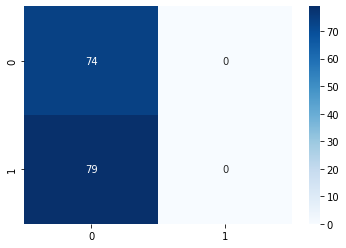

In [ ]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model_bal_smote)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True,  cmap='Blues')

# 1.4.1 GridSearch - Modelo LSTM con division manual (X_smote_float, y_smote_int)

In [ ]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_smote_float, y_smote_int)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.571440 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.509638 (0.034430) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.003636) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.003636) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.553593 (0.071279) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.003636) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.503252 (0.005393) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [ ]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f97c13e8700>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

In [ ]:
# print classification report
y_pred = final_model.predict(X_test.astype(np.float32))

print(classification_report(y_test, y_pred))

In [ ]:
print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

Conjunto de datos de validación
  Exactitud:     0.56209
  Precisión:     0.56302
  Exhaustividad: 0.55713
              precision    recall  f1-score   support

           0       0.57      0.41      0.47        74
           1       0.56      0.71      0.63        79

    accuracy                           0.56       153
   macro avg       0.56      0.56      0.55       153
weighted avg       0.56      0.56      0.55       153



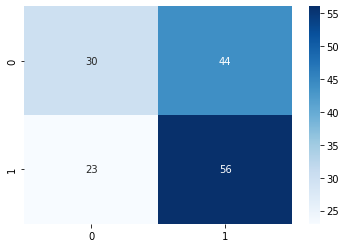

In [ ]:
y_pred = final_model.predict(X_test.astype(np.float32))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test_1, y_pred))

[[74  0]
 [79  0]]


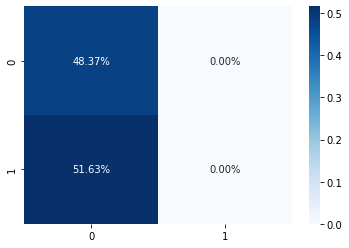

In [ ]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model_rus_1)
print(cf_matrix)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
print(classification_report(y_test_1, y_pred))

#1.5. Model LSTM clases balanceadas con RandomUnderSampler


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

X_rus , y_rus = RandomUnderSampler().fit_resample(df_train_scaled, y_train)


print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_rus.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_rus.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_rus == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_rus == 0)))

Before OverSampling, counts of label '1': 303
Before OverSampling, counts of label '0': 308 

After OverSampling, the shape of train_X: (606, 29)
After OverSampling, the shape of train_y: (606,) 

After OverSampling, counts of label '1': 303
After OverSampling, counts of label '0': 303


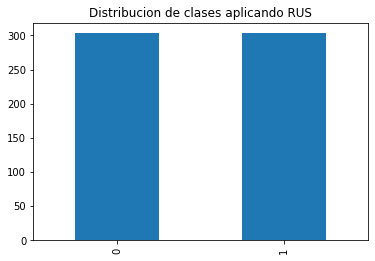

In [ ]:
pd.Series(y_rus).value_counts().plot(kind='bar', title='Distribucion de clases aplicando RUS')

In [ ]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_rus = X_rus.reshape(X_rus.shape[0],X_rus.shape[1],1)
X_rus.shape, y_rus.shape

((606, 29, 1), (606,))

In [ ]:
X_rus_float=X_rus.astype(np.float32)

In [ ]:
y_rus_int = y_rus.astype(np.int32)

In [ ]:
#Entrenamos el modelo
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=10)


model_rus = modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 32)

model_rus.fit(X_rus_float, y_rus_int, validation_data=(X_test, y_test),epochs=20,callbacks=[cp, earlyStop])


Epoch 1/20
10/19 [==============>...............] - ETA: 0s - loss: 0.7295 - accuracy: 0.4938 

19/19 [==============================] - 7s 269ms/step - loss: 0.7190 - accuracy: 0.5000 - val_loss: 0.6962 - val_accuracy: 0.4837
Epoch 2/20
11/19 [================>.............] - ETA: 0s - loss: 0.7024 - accuracy: 0.5227

19/19 [==============================] - 4s 227ms/step - loss: 0.7054 - accuracy: 0.5033 - val_loss: 0.6915 - val_accuracy: 0.5556
Epoch 3/20
11/19 [================>.............] - ETA: 0s - loss: 0.7031 - accuracy: 0.5199

19/19 [==============================] - 4s 226ms/step - loss: 0.6940 - accuracy: 0.5347 - val_loss: 0.6862 - val_accuracy: 0.5752
Epoch 4/20
18/19 [===========================>..] - ETA: 0s - loss: 0.6906 - accuracy: 0.5556

19/19 [==============================] - 5s 262ms/step - loss: 0.6900 - accuracy: 0.5545 - val_loss: 0.6845 - val_accuracy: 0.5621
Epoch 5/20
19/19 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.5281 - val_loss: 0.6854 - val_accuracy: 0.5556
Epoch 6/20
19/19 [==============================] - 0s 14ms/step - loss: 0.6785 - accuracy: 0.5627 - val_loss: 0.6847 - val_accuracy: 0.5490
Epoch 7/20
19/19 [==============================] - 0s 9ms/step - loss: 0.6879 - accuracy: 0.5627 - val_loss: 0.6862 - val_accuracy: 0.5752
Epoch 8/20
19/19 [==============================] - 0s 8ms/step - loss: 0.6819 - accuracy: 0.5809 - val_loss: 0.6876 - val_accuracy: 0.5752
Epoch 9/20
19/19 [==============================] - 0s 7ms/step - loss: 0.6768 - accuracy: 0.5858 - val_loss: 0.6881 - val_accuracy: 0.5752
Epoch 10/20
19/19 [==============================] - 0s 7ms/step - loss: 0.6812 - accuracy: 0.5842 - val_loss: 0.6898 - val_accuracy: 0.5490
Epoch 11/20
19/19 [========

In [ ]:
scores = model_rus.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_rus.metrics_names[1], scores[1] * 100))


5/5 - 0s - loss: 0.6976 - accuracy: 0.5556 - 30ms/epoch - 6ms/step
accuracy: 55.56%


In [ ]:
# print classification report
y_pred_model_rus = model_rus.predict(X_test)

y_pred_model_rus_1 = np.argmax(y_pred_model_rus, axis=1)


print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred_model_rus_1))

5/5 [==============================] - 0s 3ms/step
Conjunto de datos de validación
  Exactitud:     0.56209
  Precisión:     0.56302
  Exhaustividad: 0.55713
              precision    recall  f1-score   support

           0       0.57      0.41      0.47        74
           1       0.56      0.71      0.63        79

    accuracy                           0.56       153
   macro avg       0.56      0.56      0.55       153
weighted avg       0.56      0.56      0.55       153



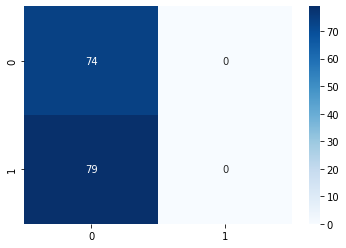

In [ ]:
cm = confusion_matrix(y_test, y_pred_model_rus_1)
sns.heatmap(cm, cmap = 'Blues', annot=True)

[[74  0]
 [79  0]]


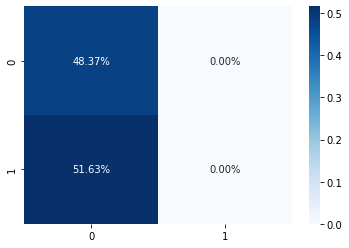

In [ ]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model_rus_1)
print(cf_matrix)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# 1.5.1 GridSearch - Modelo LSTM con division manual (X_rus_float, y_rus_int)




In [ ]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_rus_float, y_rus_int)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.592467 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.566021 (0.028176) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.003696) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.003696) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.542921 (0.034648) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.003696) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.003696) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [ ]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f97c13e8700>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

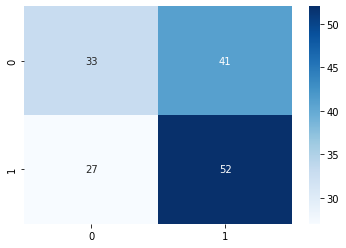

In [ ]:
y_pred = final_model.predict(X_test.astype(np.float32))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test, y_pred))

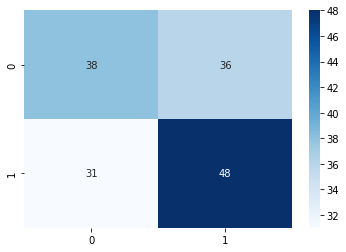

In [ ]:
y_pred = (final_model.predict_proba(X_test.astype(np.float32))[:,1] >= 0.55).astype(bool)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

Conjunto de datos de validación
  Exactitud:     0.56209
  Precisión:     0.56108
  Exhaustividad: 0.56055
              precision    recall  f1-score   support

           0       0.55      0.51      0.53        74
           1       0.57      0.61      0.59        79

    accuracy                           0.56       153
   macro avg       0.56      0.56      0.56       153
weighted avg       0.56      0.56      0.56       153



# 1.6. Model LSTM con pesos definidos por class_weight

In [ ]:
#Definimos los pesos para el balanceo de clases.
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 0.9918831168831169, 1: 1.0082508250825082}


In [ ]:
#Entrenamos el modelo
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=10)


model_class_weight = modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 32)

model_class_weight.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20,class_weight=class_weights, callbacks=[cp, earlyStop])

Epoch 1/20
17/20 [========================>.....] - ETA: 0s - loss: 0.7235 - accuracy: 0.4871

20/20 [==============================] - 7s 281ms/step - loss: 0.7222 - accuracy: 0.4894 - val_loss: 0.7005 - val_accuracy: 0.4706
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.5025

20/20 [==============================] - 5s 272ms/step - loss: 0.7010 - accuracy: 0.5025 - val_loss: 0.6979 - val_accuracy: 0.5163
Epoch 3/20
20/20 [==============================] - 0s 15ms/step - loss: 0.7013 - accuracy: 0.5057 - val_loss: 0.7008 - val_accuracy: 0.4575
Epoch 4/20
16/20 [=======================>......] - ETA: 0s - loss: 0.7029 - accuracy: 0.4922

20/20 [==============================] - 7s 384ms/step - loss: 0.7006 - accuracy: 0.5008 - val_loss: 0.6815 - val_accuracy: 0.5621
Epoch 5/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5712 - val_loss: 0.6868 - val_accuracy: 0.5556
Epoch 6/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6841 - accuracy: 0.5761 - val_loss: 0.6936 - val_accuracy: 0.4706
Epoch 7/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.5466 - val_loss: 0.6854 - val_accuracy: 0.5686
Epoch 8/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6830 - accuracy: 0.5679 - val_loss: 0.6850 - val_accuracy: 0.5621
Epoch 9/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6865 - accuracy: 0.5712 - val_loss: 0.6819 - val_accuracy: 0.5882
Epoch 10/20
11/20 [===============>..............] - ETA: 0s - loss: 0.6865 - accuracy: 0.5426

20/20 [==============================] - 5s 256ms/step - loss: 0.6784 - accuracy: 0.5679 - val_loss: 0.6778 - val_accuracy: 0.5882
Epoch 11/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6754 - accuracy: 0.5957 - val_loss: 0.6908 - val_accuracy: 0.5621
Epoch 12/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6840 - accuracy: 0.5630 - val_loss: 0.6900 - val_accuracy: 0.5556
Epoch 13/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6799 - accuracy: 0.5827 - val_loss: 0.6862 - val_accuracy: 0.5621
Epoch 14/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6824 - accuracy: 0.5385 - val_loss: 0.6989 - val_accuracy: 0.5686
Epoch 15/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6757 - accuracy: 0.5696 - val_loss: 0.6845 - val_accuracy: 0.5752
Epoch 16/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6779 - accuracy: 0.5827 - val_loss: 0.6932 - val_accuracy: 0.5686
Epoch 17/20
20/20 [====

20/20 [==============================] - 4s 226ms/step - loss: 0.6842 - accuracy: 0.5581 - val_loss: 0.6747 - val_accuracy: 0.5556
Epoch 18/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6806 - accuracy: 0.5646 - val_loss: 0.7016 - val_accuracy: 0.4967
Epoch 19/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6772 - accuracy: 0.5581 - val_loss: 0.6900 - val_accuracy: 0.5752
Epoch 20/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6767 - accuracy: 0.5761 - val_loss: 0.6784 - val_accuracy: 0.5817


In [ ]:
scores = model_class_weight.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

5/5 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5817
Accuracy: 58.17%


5/5 [==============================] - 0s 4ms/step


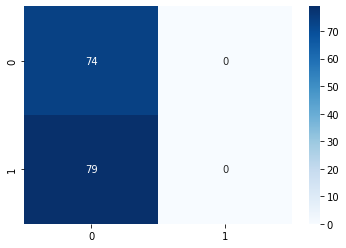

In [ ]:
y_pred_model_class = model_class_weight.predict(X_test.astype(np.float32))

y_pred_model_class = np.argmax(y_pred_model_class, axis=1)

cm = confusion_matrix(y_test, y_pred_model_class)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
print(classification_report(y_test, y_pred_model_class))

[[74  0]
 [79  0]]


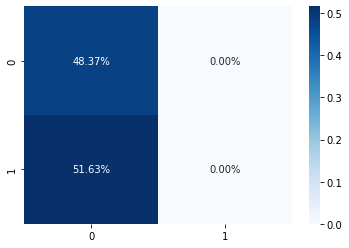

In [ ]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model_class_1)
print(cf_matrix)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

#Division Aleatoria

---



## Division aleatoria de datos

In [12]:
from sklearn.model_selection import train_test_split

df_all_20_21 = pd.read_csv("/content/drive/MyDrive/TFM/datos/df_all_20_21.csv", sep = ";")
df_all_20_21.index = df_all_20_21.fecha  ##Set_index('fecha')
df_all_20_21 = df_all_20_21.drop('fecha', axis=1)

In [13]:
df_all_20_21 = df_all_20_21.loc['2020-02-21':'2021-05-09'] 
df_all_20_21.shape

(84515, 25)

In [14]:
df_all_20_21.groupby("ocurrencia").count()

,indicativo,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,...,peligro,vulner,municipio,cod_municipio,total_viajes_estacion,total_viajes_km_estacion,laborable,dayofyear,weekend,mes
ocurrencia,,,,,,,,,,,,,,,,,,,,,
0,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,...,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133
1,382,382,382,382,382,382,382,382,382,382,...,382,382,382,382,382,382,382,382,382,382


In [15]:
df_all_20_21.groupby("ocurrencia").count().columns

Index(['indicativo', 'prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha',
       'sol', 'presMax', 'presMin', 'rhum', 'altitud',
       'porcentaje_pendiente_total', 'alto_riesgo', 'peligro', 'vulner',
       'municipio', 'cod_municipio', 'total_viajes_estacion',
       'total_viajes_km_estacion', 'laborable', 'dayofyear', 'weekend', 'mes'],
      dtype='object')

In [16]:
df_ocurrencia_0 = df_all_20_21[df_all_20_21["ocurrencia"]==0].sample(382)

In [17]:
df_ocurrencia_1 = df_all_20_21[df_all_20_21["ocurrencia"]==1]

In [18]:
df_all_20_21 =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_all_20_21.shape

(764, 25)

In [19]:
x = df_all_20_21['indicativo'].unique()
len(x)

183

In [37]:
X = df_all_20_21.drop( ['ocurrencia', 'municipio', 'cod_municipio', 'indicativo', 'total_viajes_km_estacion'], axis=1)
y = df_all_20_21['ocurrencia']

In [38]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2,  shuffle=True)
X_train_1

,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,rhum,altitud,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,total_viajes_estacion,laborable,dayofyear,weekend,mes
fecha,,,,,,,,,,,,,,,,,,,,
2020-03-06,0.0,13.0,12.4,11.8,2.7,8.7,549.0,989.1,988.7,39.0,343.0,0.50,Sí,Molt Alt,Moderada,0.00,4,66,0,3
2020-10-22,0.0,20.4,20.2,20.0,6.2,8.7,185.0,965.5,965.0,88.0,142.0,5.20,Sí,Molt Alt,Mitja,101860.39,3,296,0,10
2020-11-02,0.0,22.2,21.9,21.7,2.4,5.2,557.0,991.5,991.1,58.0,342.0,2.70,Sí,Molt Alt,Molt Alta,288365.49,0,307,0,11
2021-02-20,0.0,17.1,16.8,16.5,3.3,5.2,663.0,1017.1,1016.6,43.0,556.0,4.10,Sí,Exclos,Moderada,134961.89,5,51,1,2
2020-05-18,0.0,24.3,24.0,23.7,5.8,9.9,997.0,999.4,999.0,41.0,8.0,5.20,No,Exclos,Baixa,0.00,0,139,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-29,0.0,27.3,27.0,26.8,1.6,4.4,980.0,1015.8,1015.4,37.0,567.0,6.80,Sí,Alt,Mitja,0.00,4,150,0,5
2020-08-01,0.0,34.8,34.4,34.2,5.0,7.6,894.0,994.4,994.2,40.0,480.0,3.22,Sí,Alt,Molt Alta,171819.53,5,214,1,8
2020-08-31,0.0,21.8,21.6,21.5,2.5,6.2,925.0,939.7,939.4,36.0,1258.0,0.10,Sí,Moderat,Molt Alta,0.00,0,244,0,8


In [23]:
df_all_20_21.shape, X_train_1.shape, y_train_1.shape, X_test_1.shape, y_test_1.shape

((764, 25), (611, 21), (611,), (153, 21), (153,))

##Normalizacion datos



In [39]:
# normalizacion de los datos numericos
from sklearn.preprocessing import StandardScaler
numericalCols_train_1 = X_train_1[["prec", "tmax", "tmed", "tmin", "velmedia", "racha", "sol", "presMax", "presMin", "rhum", "altitud", "porcentaje_pendiente_total", "total_viajes_estacion"]] 
numericalCols_test_1 = X_test_1[["prec","tmed","tmax", "tmin", "velmedia", "racha", "sol", "presMax","presMin","rhum", "altitud", "porcentaje_pendiente_total", "total_viajes_estacion"]] 

scaler = StandardScaler()
scaler.fit(numericalCols_train_1)

numericalCols_train_scaled_1 = scaler.transform(numericalCols_train_1)
numericalCols_test_scaled_1 = scaler.transform(numericalCols_test_1)

numericalCols_train_scaled_1.shape , numericalCols_test_scaled_1.shape

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


((611, 13), (153, 13))

In [40]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train_1 = X_train_1[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	vulner
categoricalCols_train_1 = OneHotEncoder().fit_transform(categoricalCols_train_1).toarray()

# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test_1 = X_test_1[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	 y vulner
categoricalCols_test_1 = OneHotEncoder().fit_transform(categoricalCols_test_1).toarray()

categoricalCols_train_1.shape, categoricalCols_test_1.shape

((611, 12), (153, 12))

In [41]:
Other_var_train_1 = X_train_1[['laborable', 	'dayofyear', 	'weekend', 	'mes']]
Other_var_test_1 = X_test_1[['laborable', 	'dayofyear', 	'weekend', 	'mes']]  #alto_riesgo	peligro	 y vulner

In [42]:
df_train_scaled_1 = np.concatenate((numericalCols_train_scaled_1 , categoricalCols_train_1, Other_var_train_1), axis=1)
df_test_scaled_1 = np.concatenate((numericalCols_test_scaled_1 , categoricalCols_test_1, Other_var_test_1), axis=1)

In [43]:
df_train_scaled_1.shape, y_train_1.shape, df_test_scaled_1.shape, y_test_1.shape

((611, 29), (611,), (153, 29), (153,))

In [44]:
X_train_1 = df_train_scaled_1.reshape(df_train_scaled_1.shape[0],df_train_scaled_1.shape[1],1)
X_train_1.shape, y_train_1.shape

((611, 29, 1), (611,))

In [45]:
X_test_1 = df_test_scaled_1.reshape(df_test_scaled_1.shape[0],df_test_scaled_1.shape[1],1)
X_test_1.shape, y_test_1.shape

((153, 29, 1), (153,))

##Model LSTM (df_all_20_21)

In [46]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer


def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 32):
    model=Sequential()
    model.add(InputLayer((29,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(29, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [47]:
model_shuffle = modelLSTM()

In [48]:
model_shuffle.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 29)                5829      
                                                                 
 dropout_1 (Dropout)         (None, 29)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 30        
                                                                 
Total params: 167,459
Trainable params: 167,459
Non-trainable params: 0
_________________________________________________________________


In [49]:
#Entrenamos el modelo
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model_shuffle.fit(X_train_1, y_train_1,validation_data=(X_test_1, y_test_1),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.6979 - accuracy: 0.4959

20/20 [==============================] - 11s 242ms/step - loss: 0.6979 - accuracy: 0.4959 - val_loss: 0.6939 - val_accuracy: 0.5033
Epoch 2/20
11/20 [===============>..............] - ETA: 0s - loss: 0.7072 - accuracy: 0.4688

20/20 [==============================] - 4s 213ms/step - loss: 0.7017 - accuracy: 0.5008 - val_loss: 0.6920 - val_accuracy: 0.4967
Epoch 3/20
20/20 [==============================] - 0s 7ms/step - loss: 0.7023 - accuracy: 0.5106 - val_loss: 0.6994 - val_accuracy: 0.4379
Epoch 4/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6952 - accuracy: 0.5352 - val_loss: 0.6985 - val_accuracy: 0.4444
Epoch 5/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6951 - accuracy: 0.5221 - val_loss: 0.6922 - val_accuracy: 0.4771
Epoch 6/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6994 - accuracy: 0.5025 - val_loss: 0.6939 - val_accuracy: 0.4967
Epoch 7/20
11/20 [===============>..............] - ETA: 0s - loss: 0.6883 - accuracy: 0.5511

20/20 [==============================] - 4s 218ms/step - loss: 0.6893 - accuracy: 0.5597 - val_loss: 0.6459 - val_accuracy: 0.6405
Epoch 8/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6822 - accuracy: 0.5565 - val_loss: 0.6732 - val_accuracy: 0.5229
Epoch 9/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6911 - accuracy: 0.5254 - val_loss: 0.6560 - val_accuracy: 0.6013
Epoch 10/20
11/20 [===============>..............] - ETA: 0s - loss: 0.6853 - accuracy: 0.5682

20/20 [==============================] - 5s 238ms/step - loss: 0.6758 - accuracy: 0.5843 - val_loss: 0.6390 - val_accuracy: 0.6275
Epoch 11/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6768 - accuracy: 0.5827 - val_loss: 0.6512 - val_accuracy: 0.6275
Epoch 12/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6777 - accuracy: 0.5777 - val_loss: 0.6446 - val_accuracy: 0.6275
Epoch 13/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6741 - accuracy: 0.5892 - val_loss: 0.6580 - val_accuracy: 0.5817
Epoch 14/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6703 - accuracy: 0.5843 - val_loss: 0.6981 - val_accuracy: 0.4771
Epoch 15/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6992 - accuracy: 0.5139 - val_loss: 0.7087 - val_accuracy: 0.4379
Epoch 16/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.5286 - val_loss: 0.6933 - val_accuracy: 0.5359
Epoch 17/20
20/20 [====

In [58]:
scores = model_shuffle.evaluate(X_test_1, y_test_1, verbose=2)
print("%s: %.2f%%" % (model_shuffle.metrics_names[1], scores[1] * 100))

5/5 - 0s - loss: 0.6982 - accuracy: 0.4379 - 35ms/epoch - 7ms/step
accuracy: 43.79%


In [62]:
y_pred_model = model_shuffle.predict(X_test_1.astype('float32'))

5/5 [==============================] - 0s 3ms/step


In [65]:
from sklearn.metrics import confusion_matrix
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test_1, y_pred_model1))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72        86
           1       0.00      0.00      0.00        67

    accuracy                           0.56       153
   macro avg       0.28      0.50      0.36       153
weighted avg       0.32      0.56      0.40       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[86  0]
 [67  0]]


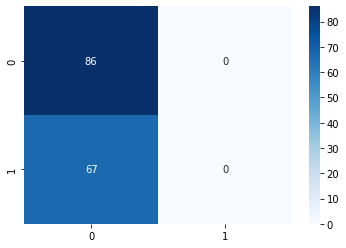

In [66]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test_1, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

# 2.2.1 GridSearch -  Hiperparametros del modelo LSTM con division aleatoria  (X_train_1, y_train_1)

In [67]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_train_1, y_train_1)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.582620 using {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.582620 (0.058848) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.518832 (0.007164) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.546701 (0.082205) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.515554 (0.001679) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.574477 (0.044487) with: {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.523724 (0.009813) with: {'batch_size': 64, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}


In [68]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7fc485604a60>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

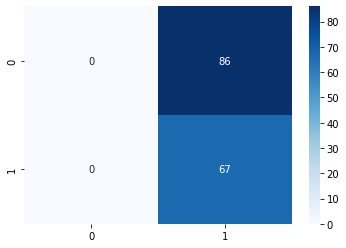

In [70]:
y_pred = final_model.predict(X_test_1.astype('float32'))

cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [71]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
           1       0.44      1.00      0.61        67

    accuracy                           0.44       153
   macro avg       0.22      0.50      0.30       153
weighted avg       0.19      0.44      0.27       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


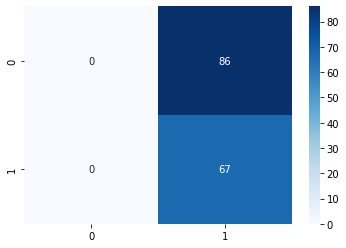

In [74]:
y_pred = (final_model.predict_proba(X_test_1)[:,1] >= 0.31).astype(bool)
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [75]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
           1       0.44      1.00      0.61        67

    accuracy                           0.44       153
   macro avg       0.22      0.50      0.30       153
weighted avg       0.19      0.44      0.27       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#2.3. Model LSTM division aleatoria con SMOTE

In [76]:
from imblearn.over_sampling import SMOTE 
X_smote , y_smote = SMOTE().fit_resample( df_train_scaled_1, y_train_1)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train_1 == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train_1 == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_smote.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote == 0)))

Before OverSampling, counts of label '1': 315
Before OverSampling, counts of label '0': 296 

After OverSampling, the shape of train_X: (630, 29)
After OverSampling, the shape of train_y: (630,) 

After OverSampling, counts of label '1': 315
After OverSampling, counts of label '0': 315


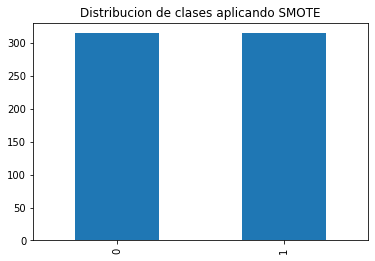

In [77]:
pd.Series(y_smote).value_counts().plot(kind='bar', title='Distribucion de clases aplicando SMOTE')

Este gráfico muestra claramente que ahora tenemos una gran cantidad de incendios que antes no teníamos. Esos son todos los puntos de datos sintéticos que se ha creado con SMOTE.



In [78]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_smote = X_smote.reshape(X_smote.shape[0],X_smote.shape[1],1)
X_smote.shape, y_smote.shape

((630, 29, 1), (630,))

In [79]:
X_smote_float=X_smote.astype(np.float32)

In [80]:
y_smote_int = y_smote.astype(np.int32)

In [81]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=10)

model_smote = modelLSTM(200, 'sigmoid', 0.2,'adam')

model_smote.fit(X_smote_float, y_smote_int,validation_data=(X_test_1, y_test_1),epochs=20,callbacks=[cp, earlyStop])

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.7234 - accuracy: 0.4810

20/20 [==============================] - 6s 241ms/step - loss: 0.7234 - accuracy: 0.4810 - val_loss: 0.7009 - val_accuracy: 0.4379
Epoch 2/20
11/20 [===============>..............] - ETA: 0s - loss: 0.7143 - accuracy: 0.5057

20/20 [==============================] - 4s 203ms/step - loss: 0.7141 - accuracy: 0.5032 - val_loss: 0.7001 - val_accuracy: 0.4379
Epoch 3/20
11/20 [===============>..............] - ETA: 0s - loss: 0.7051 - accuracy: 0.4574

20/20 [==============================] - 4s 226ms/step - loss: 0.7005 - accuracy: 0.4841 - val_loss: 0.6931 - val_accuracy: 0.4902
Epoch 4/20
11/20 [===============>..............] - ETA: 0s - loss: 0.6949 - accuracy: 0.5000

20/20 [==============================] - 4s 203ms/step - loss: 0.6939 - accuracy: 0.5175 - val_loss: 0.6813 - val_accuracy: 0.5359
Epoch 5/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6900 - accuracy: 0.5254 - val_loss: 0.6935 - val_accuracy: 0.4902
Epoch 6/20
20/20 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.5460

20/20 [==============================] - 4s 227ms/step - loss: 0.6814 - accuracy: 0.5460 - val_loss: 0.6318 - val_accuracy: 0.6275
Epoch 7/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6804 - accuracy: 0.5810 - val_loss: 0.6459 - val_accuracy: 0.6471
Epoch 8/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6844 - accuracy: 0.5683 - val_loss: 0.6633 - val_accuracy: 0.6405
Epoch 9/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6783 - accuracy: 0.5746 - val_loss: 0.6645 - val_accuracy: 0.6078
Epoch 10/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6780 - accuracy: 0.5381 - val_loss: 0.6467 - val_accuracy: 0.6078
Epoch 11/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6771 - accuracy: 0.5698 - val_loss: 0.6582 - val_accuracy: 0.6013
Epoch 12/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6735 - accuracy: 0.5698 - val_loss: 0.6341 - val_accuracy: 0.6209
Epoch 13/20
20/20 [=======

In [82]:
scores = model_smote.evaluate(X_test_1, y_test_1, verbose=2)
print("%s: %.2f%%" % (model_smote.metrics_names[1], scores[1] * 100))


5/5 - 0s - loss: 0.6367 - accuracy: 0.6209 - 28ms/epoch - 6ms/step
accuracy: 62.09%


In [83]:
# print classification report
y_pred_model_bal = model_smote.predict(X_test_1)

y_pred_model_bal_1 = np.argmax(y_pred_model_bal, axis=1)
print(classification_report(y_test_1, y_pred_model_bal_1))

5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        86
           1       0.00      0.00      0.00        67

    accuracy                           0.56       153
   macro avg       0.28      0.50      0.36       153
weighted avg       0.32      0.56      0.40       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[86  0]
 [67  0]]


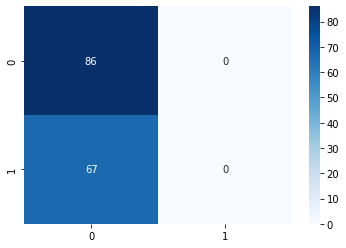

In [84]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test_1, y_pred_model_bal_1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True,  cmap='Blues')

# 2.3.1 GridSearch - Modelo LSTM con division aleatoria Smote (X_smote_float, y_smote_int)

In [85]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_smote_float, y_smote_int)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.573016 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.528571 (0.071446) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.501587 (0.003175) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.000000) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.555556 (0.044046) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.498413 (0.003175) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.498413 (0.003175) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [86]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7fc485604a60>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

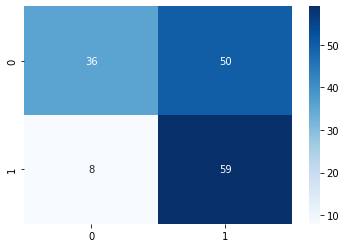

In [88]:
y_pred = final_model.predict(X_test_1.astype('float32'))

cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [89]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.42      0.55        86
           1       0.54      0.88      0.67        67

    accuracy                           0.62       153
   macro avg       0.68      0.65      0.61       153
weighted avg       0.70      0.62      0.60       153



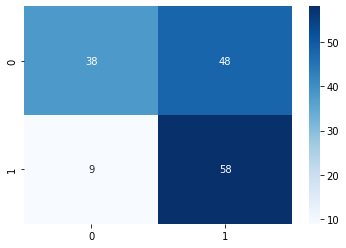

In [97]:
y_pred = (final_model.predict_proba(X_test_1.astype('float32'))[:,1] >= 0.52).astype(bool)
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [98]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.44      0.57        86
           1       0.55      0.87      0.67        67

    accuracy                           0.63       153
   macro avg       0.68      0.65      0.62       153
weighted avg       0.69      0.63      0.61       153



# 2.4 Model LSTM - Division Aleatoria - Balanceo de clases RandomUnderSampler (y_train_1)


In [99]:
from imblearn.under_sampling import RandomUnderSampler

X_rus , y_rus = RandomUnderSampler().fit_resample(df_train_scaled_1, y_train_1)

print("Before UnderSampling, counts of label '1': {}".format(sum(y_train_1 == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train_1 == 0)))

print('After UnderSampling, the shape of train_X: {}'.format(X_rus.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_rus.shape))
  
print("After UnderSampling, counts of label '1': {}".format(sum(y_rus == 1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_rus == 0)))

Before UnderSampling, counts of label '1': 315
Before UnderSampling, counts of label '0': 296 

After UnderSampling, the shape of train_X: (592, 29)
After UnderSampling, the shape of train_y: (592,) 

After UnderSampling, counts of label '1': 296
After UnderSampling, counts of label '0': 296


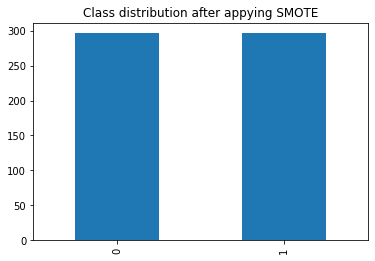

In [100]:
pd.Series(y_rus).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE')

In [101]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_rus = X_rus.reshape(X_rus.shape[0],X_rus.shape[1],1)
X_rus.shape, y_rus.shape

((592, 29, 1), (592,))

In [102]:
X_rus_float = X_rus.astype(np.float32)

In [103]:
y_rus_int = y_rus.astype(np.int32)

In [104]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=20)

model_shuffle_rus = modelLSTM(200, 'sigmoid', 0.2,'adam')

model_shuffle_rus.fit(X_rus_float, y_rus_int,validation_data=(X_test_1, y_test_1),epochs=20,callbacks=[cp, earlyStop])

Epoch 1/20
11/19 [================>.............] - ETA: 0s - loss: 0.7003 - accuracy: 0.5369 

19/19 [==============================] - 6s 254ms/step - loss: 0.6954 - accuracy: 0.5490 - val_loss: 0.6956 - val_accuracy: 0.4967
Epoch 2/20
11/19 [================>.............] - ETA: 0s - loss: 0.7227 - accuracy: 0.4886

19/19 [==============================] - 4s 212ms/step - loss: 0.7165 - accuracy: 0.4831 - val_loss: 0.6939 - val_accuracy: 0.5556
Epoch 3/20
10/19 [==============>...............] - ETA: 0s - loss: 0.6937 - accuracy: 0.5031

19/19 [==============================] - 4s 240ms/step - loss: 0.7035 - accuracy: 0.4764 - val_loss: 0.6910 - val_accuracy: 0.5490
Epoch 4/20
11/19 [================>.............] - ETA: 0s - loss: 0.7014 - accuracy: 0.4886

19/19 [==============================] - 4s 213ms/step - loss: 0.7049 - accuracy: 0.4848 - val_loss: 0.6652 - val_accuracy: 0.6209
Epoch 5/20
11/19 [================>.............] - ETA: 0s - loss: 0.6769 - accuracy: 0.5824

19/19 [==============================] - 4s 211ms/step - loss: 0.6875 - accuracy: 0.5591 - val_loss: 0.6411 - val_accuracy: 0.6340
Epoch 6/20
19/19 [==============================] - 0s 7ms/step - loss: 0.6883 - accuracy: 0.5845 - val_loss: 0.6583 - val_accuracy: 0.6275
Epoch 7/20
19/19 [==============================] - 0s 7ms/step - loss: 0.6718 - accuracy: 0.6014 - val_loss: 0.6413 - val_accuracy: 0.6275
Epoch 8/20
19/19 [==============================] - 0s 6ms/step - loss: 0.6843 - accuracy: 0.5659 - val_loss: 0.6439 - val_accuracy: 0.6471
Epoch 9/20
19/19 [==============================] - 0s 6ms/step - loss: 0.6775 - accuracy: 0.5929 - val_loss: 0.6420 - val_accuracy: 0.6667
Epoch 10/20
12/19 [=================>............] - ETA: 0s - loss: 0.6842 - accuracy: 0.5677

19/19 [==============================] - 4s 240ms/step - loss: 0.6811 - accuracy: 0.5760 - val_loss: 0.6396 - val_accuracy: 0.6667
Epoch 11/20
11/19 [================>.............] - ETA: 0s - loss: 0.6769 - accuracy: 0.5710

19/19 [==============================] - 4s 211ms/step - loss: 0.6791 - accuracy: 0.5794 - val_loss: 0.6373 - val_accuracy: 0.6601
Epoch 12/20
19/19 [==============================] - 0s 7ms/step - loss: 0.6784 - accuracy: 0.5777 - val_loss: 0.6447 - val_accuracy: 0.6667
Epoch 13/20
19/19 [==============================] - 0s 7ms/step - loss: 0.6758 - accuracy: 0.5912 - val_loss: 0.6522 - val_accuracy: 0.6275
Epoch 14/20
19/19 [==============================] - 0s 6ms/step - loss: 0.6784 - accuracy: 0.5557 - val_loss: 0.6604 - val_accuracy: 0.6340
Epoch 15/20
19/19 [==============================] - 0s 6ms/step - loss: 0.6748 - accuracy: 0.5777 - val_loss: 0.6513 - val_accuracy: 0.6601
Epoch 16/20
19/19 [==============================] - 0s 6ms/step - loss: 0.6759 - accuracy: 0.5777 - val_loss: 0.6473 - val_accuracy: 0.6601
Epoch 17/20
19/19 [==============================] - 0s 6ms/step - loss: 0.6705 - accuracy: 0.5963 - val_loss: 0.6491 - val_accuracy: 0.6601
Epoch 18/20
19/19 [====

In [105]:
scores = model_shuffle_rus.evaluate(X_test_1, y_test_1, verbose=2)
print("%s: %.2f%%" % (model_shuffle_rus.metrics_names[1], scores[1] * 100))


5/5 - 0s - loss: 0.6435 - accuracy: 0.6667 - 25ms/epoch - 5ms/step
accuracy: 66.67%


In [106]:
# print classification report
y_pred_model_bal = model_shuffle_rus.predict(X_test_1)

y_pred_model_bal_1 = np.argmax(y_pred_model_bal, axis=1)
print(classification_report(y_test_1, y_pred_model_bal_1))

5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        86
           1       0.00      0.00      0.00        67

    accuracy                           0.56       153
   macro avg       0.28      0.50      0.36       153
weighted avg       0.32      0.56      0.40       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[86  0]
 [67  0]]


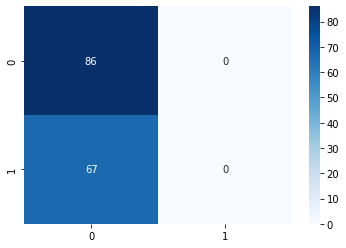

In [107]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test_1, y_pred_model_bal_1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True,  cmap='Blues')

# GridSearch - Modelo LSTM con division manual (X_rus, y_rus)

In [108]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_rus_float, y_rus_int)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.567483 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.489831 (0.043315) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.503404 (0.011169) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.002657) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.552343 (0.048373) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.501681 (0.005699) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.498305 (0.004307) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [109]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7fc485604a60>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

In [110]:
y_pred = final_model.predict(X_test_1.astype(np.float32))

In [111]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.47      0.58        86
           1       0.54      0.82      0.65        67

    accuracy                           0.62       153
   macro avg       0.66      0.64      0.62       153
weighted avg       0.67      0.62      0.61       153



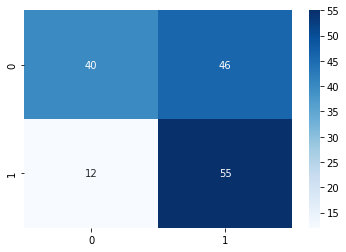

In [112]:
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

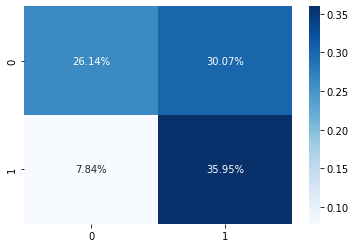

In [113]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

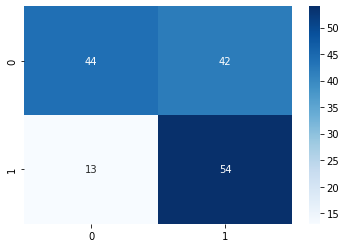

In [123]:
y_pred = (final_model.predict_proba(X_test_1.astype(np.float32))[:,1] >= 0.52).astype(bool)
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [124]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.51      0.62        86
           1       0.56      0.81      0.66        67

    accuracy                           0.64       153
   macro avg       0.67      0.66      0.64       153
weighted avg       0.68      0.64      0.64       153



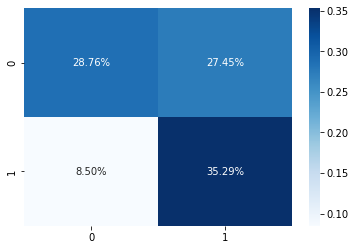

In [125]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

In [126]:
print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test_1, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test_1, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test_1, y_pred, average = "macro") :0.5f}')


Conjunto de datos de validación
  Exactitud:     0.64052
  Precisión:     0.66721
  Exhaustividad: 0.65880


#Variables importantes (Modelo Simple)

---



#Seleccion de variables importantes (Modelo Simple)


In [127]:
df_all_20_21.columns

Index(['indicativo', 'prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha',
       'sol', 'presMax', 'presMin', 'rhum', 'altitud',
       'porcentaje_pendiente_total', 'alto_riesgo', 'peligro', 'vulner',
       'ocurrencia', 'municipio', 'cod_municipio', 'total_viajes_estacion',
       'total_viajes_km_estacion', 'laborable', 'dayofyear', 'weekend', 'mes'],
      dtype='object')

In [128]:
df_all_20_21_importances = df_all_20_21.drop([ 'indicativo', 'tmed', 'tmin', 'presMin', 'municipio', 'cod_municipio', 'porcentaje_pendiente_total','altitud', 'vulner', 'alto_riesgo',  'total_viajes_km_estacion', 'laborable', 'weekend'], axis=1)
df_all_20_21_importances

,prec,tmax,velmedia,racha,sol,presMax,rhum,peligro,ocurrencia,total_viajes_estacion,dayofyear,mes
fecha,,,,,,,,,,,,
2020-08-11,0.0,31.3,1.3,3.3,390.0,997.8,30.0,Molt Alt,0,3.396048e+05,224,8
2020-07-11,0.0,30.8,5.1,8.1,928.0,996.8,55.0,Molt Alt,0,3.193670e+06,193,7
2021-03-01,0.0,12.7,1.6,4.9,413.0,926.7,59.0,Alt,0,0.000000e+00,60,3
2021-04-19,0.0,17.9,1.9,4.1,856.0,1014.9,60.0,Molt Alt,0,1.688171e+04,109,4
2020-12-14,0.0,14.8,1.1,2.1,247.0,1013.0,74.0,Exclos,0,2.992088e+05,349,12
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-08,0.0,25.5,2.5,7.1,953.0,1013.2,51.0,Molt Alt,1,0.000000e+00,128,5
2021-05-08,0.0,25.5,4.9,8.6,960.0,1003.5,47.0,Exclos,1,5.151843e+05,128,5
2021-05-08,0.0,27.8,2.4,4.8,923.0,1016.3,43.0,Molt Alt,1,1.369186e+05,128,5


In [129]:
df_all_20_21_importances.groupby("ocurrencia").count()

,prec,tmax,velmedia,racha,sol,presMax,rhum,peligro,total_viajes_estacion,dayofyear,mes
ocurrencia,,,,,,,,,,,
0,382,382,382,382,382,382,382,382,382,382,382
1,382,382,382,382,382,382,382,382,382,382,382


In [130]:
df_all_20_21_importances.groupby("ocurrencia").count().columns

Index(['prec', 'tmax', 'velmedia', 'racha', 'sol', 'presMax', 'rhum',
       'peligro', 'total_viajes_estacion', 'dayofyear', 'mes'],
      dtype='object')

In [131]:
df_ocurrencia_0 = df_all_20_21_importances[df_all_20_21_importances["ocurrencia"]==0]  #.sample(382)

In [132]:
df_ocurrencia_1 = df_all_20_21_importances[df_all_20_21_importances["ocurrencia"]==1]

In [133]:
df_all_20_21_importances =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_all_20_21_importances.shape
df_all_20_21_importances

,prec,tmax,velmedia,racha,sol,presMax,rhum,peligro,ocurrencia,total_viajes_estacion,dayofyear,mes
fecha,,,,,,,,,,,,
2020-08-11,0.0,31.3,1.3,3.3,390.0,997.8,30.0,Molt Alt,0,3.396048e+05,224,8
2020-07-11,0.0,30.8,5.1,8.1,928.0,996.8,55.0,Molt Alt,0,3.193670e+06,193,7
2021-03-01,0.0,12.7,1.6,4.9,413.0,926.7,59.0,Alt,0,0.000000e+00,60,3
2021-04-19,0.0,17.9,1.9,4.1,856.0,1014.9,60.0,Molt Alt,0,1.688171e+04,109,4
2020-12-14,0.0,14.8,1.1,2.1,247.0,1013.0,74.0,Exclos,0,2.992088e+05,349,12
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-08,0.0,25.5,2.5,7.1,953.0,1013.2,51.0,Molt Alt,1,0.000000e+00,128,5
2021-05-08,0.0,25.5,4.9,8.6,960.0,1003.5,47.0,Exclos,1,5.151843e+05,128,5
2021-05-08,0.0,27.8,2.4,4.8,923.0,1016.3,43.0,Molt Alt,1,1.369186e+05,128,5


In [134]:
X = df_all_20_21_importances.drop( ['ocurrencia'], axis=1)
y = df_all_20_21_importances['ocurrencia']

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [136]:
df_all_20_21.shape,  X_train.shape, y_train.shape, X_test.shape, y_test.shape

((764, 25), (611, 11), (611,), (153, 11), (153,))

In [137]:
# normalizacion de los datos numericos
numericalCols_train = X_train[['prec'	,'tmax',	'velmedia',	'racha',	'sol'	,'presMax',	'rhum','total_viajes_estacion']]
numericalCols_test = X_test[['prec'	,'tmax',	'velmedia',	'racha',	'sol'	,'presMax',	'rhum','total_viajes_estacion']]

scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((611, 8), (153, 8))

In [138]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train = X_train[[	'peligro']]  #alto_riesgo	peligro	vulner
categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()


# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test = X_test[['peligro']]   #alto_riesgo	peligro	 y vulner
categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

categoricalCols_train.shape, categoricalCols_test.shape

((611, 5), (153, 5))

In [139]:
Other_var_train = X_train[[	'mes', 'dayofyear']]
Other_var_test = X_test[[	'mes', 'dayofyear']]  #alto_riesgo	peligro	 y vulner

In [140]:
df_train_scaled = np.concatenate((numericalCols_train_scaled , categoricalCols_train, Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled , categoricalCols_test, Other_var_test), axis=1)

In [141]:
df_train_scaled.shape, y_train.shape, df_test_scaled.shape, y_test.shape

((611, 15), (611,), (153, 15), (153,))

In [142]:
X_test = df_test_scaled
X_train = df_train_scaled

##Model LSTM

In [143]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer


def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 64):
    model=Sequential()
    model.add(InputLayer((15,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(15, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [144]:
model_import = modelLSTM()

In [145]:
model_import.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 200)               161600    
                                                                 
 dropout_12 (Dropout)        (None, 200)               0         
                                                                 
 dense_12 (Dense)            (None, 15)                3015      
                                                                 
 dropout_13 (Dropout)        (None, 15)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 16        
                                                                 
Total params: 164,631
Trainable params: 164,631
Non-trainable params: 0
_________________________________________________________________


In [146]:
#Entrenamos el modelo
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model_import.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
12/20 [=================>............] - ETA: 0s - loss: 0.7097 - accuracy: 0.4896 

20/20 [==============================] - 6s 235ms/step - loss: 0.7155 - accuracy: 0.4795 - val_loss: 0.6942 - val_accuracy: 0.4902
Epoch 2/20
20/20 [==============================] - 0s 8ms/step - loss: 0.6985 - accuracy: 0.5237 - val_loss: 0.7021 - val_accuracy: 0.5294
Epoch 3/20
16/20 [=======================>......] - ETA: 0s - loss: 0.6967 - accuracy: 0.5293

20/20 [==============================] - 4s 230ms/step - loss: 0.6949 - accuracy: 0.5254 - val_loss: 0.6900 - val_accuracy: 0.5163
Epoch 4/20
13/20 [==================>...........] - ETA: 0s - loss: 0.6777 - accuracy: 0.5817

20/20 [==============================] - 4s 199ms/step - loss: 0.6833 - accuracy: 0.5679 - val_loss: 0.6888 - val_accuracy: 0.5490
Epoch 5/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6745 - accuracy: 0.6056 - val_loss: 0.6907 - val_accuracy: 0.5359
Epoch 6/20
13/20 [==================>...........] - ETA: 0s - loss: 0.6755 - accuracy: 0.5889

20/20 [==============================] - 4s 199ms/step - loss: 0.6775 - accuracy: 0.5810 - val_loss: 0.6882 - val_accuracy: 0.5359
Epoch 7/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6603 - accuracy: 0.6023 - val_loss: 0.7062 - val_accuracy: 0.5359
Epoch 8/20
14/20 [====================>.........] - ETA: 0s - loss: 0.6699 - accuracy: 0.5938

20/20 [==============================] - 4s 229ms/step - loss: 0.6677 - accuracy: 0.5859 - val_loss: 0.6869 - val_accuracy: 0.5359
Epoch 9/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6596 - accuracy: 0.5679 - val_loss: 0.6942 - val_accuracy: 0.5294
Epoch 10/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6731 - accuracy: 0.5794 - val_loss: 0.6870 - val_accuracy: 0.5425
Epoch 11/20
20/20 [==============================] - 0s 5ms/step - loss: 0.6590 - accuracy: 0.5925 - val_loss: 0.6986 - val_accuracy: 0.5425
Epoch 12/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6688 - accuracy: 0.6007 - val_loss: 0.6955 - val_accuracy: 0.5294
Epoch 13/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6626 - accuracy: 0.5827 - val_loss: 0.6969 - val_accuracy: 0.5229
Epoch 14/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6598 - accuracy: 0.6023 - val_loss: 0.7115 - val_accuracy: 0.5359
Epoch 15/20
20/20 [=====

In [147]:
scores = model_import.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_import.metrics_names[1], scores[1] * 100))

5/5 - 0s - loss: 0.6955 - accuracy: 0.4967 - 25ms/epoch - 5ms/step
accuracy: 49.67%


In [148]:
y_pred_model_1 = model_import.predict(X_test)

5/5 [==============================] - 0s 3ms/step


In [149]:
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test, y_pred_model1))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68        78
           1       0.00      0.00      0.00        75

    accuracy                           0.51       153
   macro avg       0.25      0.50      0.34       153
weighted avg       0.26      0.51      0.34       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[78  0]
 [75  0]]


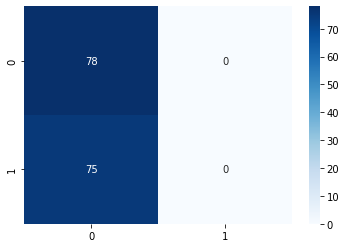

In [150]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

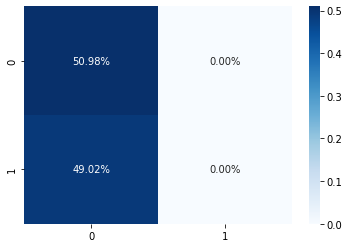

In [151]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')